# Try a RNN as an embedding net that handles 6 dimensions and embeds it into 25 dimensions to infer 3 parameters in NPE, non-sequential

## We have an input size of 6 (6dimensions)

In [14]:
# Import Libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [30]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
        [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
        ...,
        [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
        [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
        [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]])

In [31]:
true_data.shape

torch.Size([1000, 6])

In [32]:
print(true_data.size(0), true_data.size(-1))

1000 6


In [34]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)
        #self.tanh = nn.Tanh()

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(gru_out[:, -1, :]) #no tanh
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [35]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [36]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=25, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [37]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 259 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

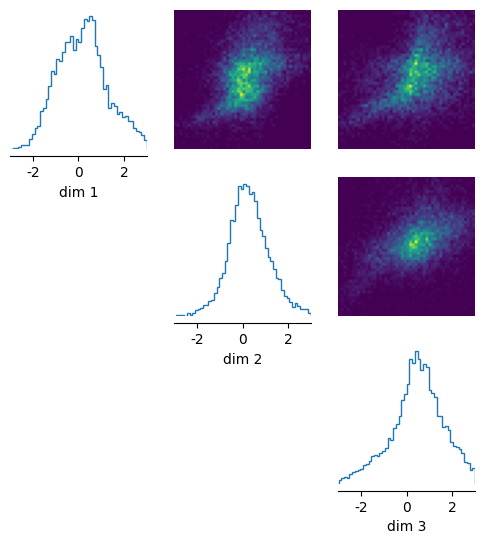

In [39]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)

# Now try to do the same in a sequential model, in a sequential model with 3 rounds of 500 sims

In [28]:
#Code simulator and everything else as always
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

num_timesteps = 1000  # Number of time steps for simulation

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
        [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
        ...,
        [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
        [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
        [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]])

In [27]:
#We have 1000 timepoints and 6 dimensions
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, _ = self.gru(
            x, h)
        output = self.linear(gru_out[:, -1, :])
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [29]:
# set prior distribution for the parameters
num_dim = 3
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

# 3 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 3

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    simulator, prior = prepare_for_sbi(simulator, prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=10)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

 Neural network successfully converged after 109 epochs.

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Training neural network. Epochs trained: 1

 Training neural network. Epochs trained: 2

 Training neural network. Epochs trained: 3

 Training neural network. Epochs trained: 4

 Training neural network. Epochs trained: 5

 Training neural network. Epochs trained: 6

 Training neural network. Epochs trained: 7

 Training neural network. Epochs trained: 8

 Training neural network. Epochs trained: 9

 Training neural network. Epochs trained: 10

 Training neural network. Epochs trained: 11

 Training neural network. Epochs trained: 12

 Training neural network. Epochs trained: 13

 Training neural network. Epochs trained: 14

 Training neural network. Epochs trained: 15

 Training neural network. Epochs trained: 16

 Training neural network. Epochs trained: 17

 Training neural network. Epochs trained: 18

 Training neural network. Epochs trained: 19

 Training neural network. Epochs trained: 20

 Training neural network. Epochs trained: 21

 Training neural network. Epochs trained: 22

 Training neural network. Epochs trained: 23

 Training neural network. Epochs trained: 24

 Training neural network. Epochs trained: 25

 Training neural network. Epochs trained: 26

 Training neural network. Epochs trained: 27

 Training neural network. Epochs trained: 28

 Training neural network. Epochs trained: 29

 Training neural network. Epochs trained: 30

 Training neural network. Epochs trained: 31

 Training neural network. Epochs trained: 32

 Training neural network. Epochs trained: 33

 Training neural network. Epochs trained: 34

 Training neural network. Epochs trained: 35

 Training neural network. Epochs trained: 36

 Training neural network. Epochs trained: 37

 Training neural network. Epochs trained: 38

 Training neural network. Epochs trained: 39

 Training neural network. Epochs trained: 40

 Training neural network. Epochs trained: 41

 Training neural network. Epochs trained: 42

 Training neural network. Epochs trained: 43

 Training neural network. Epochs trained: 44

 Training neural network. Epochs trained: 45

 Training neural network. Epochs trained: 46

 Training neural network. Epochs trained: 47

 Training neural network. Epochs trained: 48

 Training neural network. Epochs trained: 49

 Training neural network. Epochs trained: 50

 Training neural network. Epochs trained: 51

 Training neural network. Epochs trained: 52

 Training neural network. Epochs trained: 53

 Training neural network. Epochs trained: 54

 Training neural network. Epochs trained: 55

 Training neural network. Epochs trained: 56

 Training neural network. Epochs trained: 57

 Training neural network. Epochs trained: 58

 Training neural network. Epochs trained: 59

 Training neural network. Epochs trained: 60

 Training neural network. Epochs trained: 61

 Training neural network. Epochs trained: 62

 Training neural network. Epochs trained: 63

 Training neural network. Epochs trained: 64

 Training neural network. Epochs trained: 65

 Training neural network. Epochs trained: 66

 Training neural network. Epochs trained: 67

 Training neural network. Epochs trained: 68

 Training neural network. Epochs trained: 69

 Training neural network. Epochs trained: 70

 Training neural network. Epochs trained: 71

 Training neural network. Epochs trained: 72

 Training neural network. Epochs trained: 73

 Training neural network. Epochs trained: 74

 Training neural network. Epochs trained: 75

 Training neural network. Epochs trained: 76

 Training neural network. Epochs trained: 77

 Training neural network. Epochs trained: 78

 Training neural network. Epochs trained: 79

 Training neural network. Epochs trained: 80

 Training neural network. Epochs trained: 81

 Training neural network. Epochs trained: 82

 Training neural network. Epochs trained: 83

 Training neural network. Epochs trained: 84

 Training neural network. Epochs trained: 85

 Training neural network. Epochs trained: 86

 Training neural network. Epochs trained: 87

 Training neural network. Epochs trained: 88

 Training neural network. Epochs trained: 89

 Training neural network. Epochs trained: 90

 Training neural network. Epochs trained: 91

 Training neural network. Epochs trained: 92

 Training neural network. Epochs trained: 93

 Training neural network. Epochs trained: 94

 Training neural network. Epochs trained: 95

 Training neural network. Epochs trained: 96

 Training neural network. Epochs trained: 97

 Training neural network. Epochs trained: 98

 Training neural network. Epochs trained: 99

 Training neural network. Epochs trained: 100

 Training neural network. Epochs trained: 101

 Training neural network. Epochs trained: 102

 Training neural network. Epochs trained: 103

 Training neural network. Epochs trained: 104

 Training neural network. Epochs trained: 105

 Training neural network. Epochs trained: 106

 Training neural network. Epochs trained: 107

 Training neural network. Epochs trained: 108

 Training neural network. Epochs trained: 109

 Training neural network. Epochs trained: 110

 Training neural network. Epochs trained: 111

 Training neural network. Epochs trained: 112

 Training neural network. Epochs trained: 113

 Training neural network. Epochs trained: 114

 Training neural network. Epochs trained: 115

 Training neural network. Epochs trained: 116

 Training neural network. Epochs trained: 117

 Training neural network. Epochs trained: 118

 Training neural network. Epochs trained: 119

 Training neural network. Epochs trained: 120

 Training neural network. Epochs trained: 121

 Training neural network. Epochs trained: 122

 Training neural network. Epochs trained: 123

 Training neural network. Epochs trained: 124

 Training neural network. Epochs trained: 125

 Training neural network. Epochs trained: 126

 Training neural network. Epochs trained: 127

 Training neural network. Epochs trained: 128

 Training neural network. Epochs trained: 129

 Training neural network. Epochs trained: 130

 Training neural network. Epochs trained: 131

 Training neural network. Epochs trained: 132

 Training neural network. Epochs trained: 133

 Training neural network. Epochs trained: 134

 Training neural network. Epochs trained: 135

 Training neural network. Epochs trained: 136

 Training neural network. Epochs trained: 137

 Training neural network. Epochs trained: 138

 Training neural network. Epochs trained: 139

 Training neural network. Epochs trained: 140

 Training neural network. Epochs trained: 141

 Training neural network. Epochs trained: 142

 Training neural network. Epochs trained: 143

 Training neural network. Epochs trained: 144

 Training neural network. Epochs trained: 145

 Training neural network. Epochs trained: 146

 Training neural network. Epochs trained: 147

 Training neural network. Epochs trained: 148

 Training neural network. Epochs trained: 149

 Training neural network. Epochs trained: 150

 Training neural network. Epochs trained: 151

 Training neural network. Epochs trained: 152

 Training neural network. Epochs trained: 153

 Training neural network. Epochs trained: 154

 Training neural network. Epochs trained: 155

 Training neural network. Epochs trained: 156

 Training neural network. Epochs trained: 157

 Training neural network. Epochs trained: 158

 Training neural network. Epochs trained: 159

 Training neural network. Epochs trained: 160

 Training neural network. Epochs trained: 161

 Training neural network. Epochs trained: 162

 Training neural network. Epochs trained: 163

 Training neural network. Epochs trained: 164

 Training neural network. Epochs trained: 165

 Training neural network. Epochs trained: 166

 Training neural network. Epochs trained: 167

 Training neural network. Epochs trained: 168

 Training neural network. Epochs trained: 169

 Training neural network. Epochs trained: 170

 Training neural network. Epochs trained: 171

 Training neural network. Epochs trained: 172

KeyboardInterrupt: 

In [ ]:
posterior_samples = posteriors.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(6, 6)
)